In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
league_url = "https://fantasy.premierleague.com/api/leagues-classic/741461/standings/"
league_info = requests.get(league_url).json()

standings = league_info['standings']['results']
df_standings = pd.DataFrame(standings)

df_gw = pd.DataFrame()
for i in range(len(df_standings)):    
    entry = df_standings['entry'][i]
    for j in range(1, 21):
        gw_url = "https://fantasy.premierleague.com/api/entry/" + str(entry) + "/event/"+ str(j)+ "/picks/"
        gw = requests.get(gw_url).json()
        chip = gw['active_chip']
        points = gw['entry_history']['points']
        transfers = gw['entry_history']['event_transfers']
        transfers_cost = gw['entry_history']['event_transfers_cost']
        bench_points = gw['entry_history']['points_on_bench']
        df = pd.DataFrame(gw['picks'])
        df['entry'] = entry
        df['round'] = j
        df['points'] = points
        df['transfers'] = transfers
        df['transfers_cost'] = transfers_cost
        df['bench_points'] = bench_points
        df['chip'] = chip
        df_gw = pd.concat([df_gw, df], ignore_index = True)

url = "https://fantasy.premierleague.com/api/bootstrap-static/"
info = requests.get(url).json()
df_elements = pd.DataFrame(info['elements'])
df_elements = df_elements[['id', 'first_name', 'second_name', 'element_type']]
df_elements = df_elements.rename(columns = {'id': 'element'})

df_merge = df_gw.merge(df_elements, how = 'left', on = ['element'])

df_player = pd.DataFrame()
elements = df_gw['element'].unique()
elements.sort()
for i in range(len(elements)):
    player_id = elements[i]
    player_url = "https://fantasy.premierleague.com/api/element-summary/" +str(player_id) + "/"
    player_info = requests.get(player_url).json()    
    df = pd.DataFrame(player_info['history'])
    df = df[['element', 'round', 'total_points', 'minutes', 'value']]
    df_player = pd.concat([df_player, df], ignore_index = True)

df_merge = df_merge.merge(df_player, how = 'left', on = ['element', 'round'])

In [3]:
df_merge.to_csv('fpl_dataset.csv', index = False)
df_standings.to_csv('league_standings.csv', index = False)

In [4]:
palette = ['#C7675D', '#1E81B0', '#2596BE', '#556B2F', '#4BD9C1', '#FF0000', '#FFBE98', '#17993C', 
           '#00FF00', '#9DBC98', '#4B5320', '#A3DBDB', '#FF4F4F', '#0000FF', '#34BAEB', '#FF9933']
df_standings['palette'] = palette

player_names = df_standings['player_name'].str.split(pat = ' ', expand = True)
df_standings['player_name'] = player_names[0]
managers = df_standings[['entry', 'player_name', 'palette']]

In [5]:
def max_starting11_points(df, gw, entry_id):
    df_gw = df[(df['entry'] == entry_id) & (df['round'] == gw)].reset_index()  
    actual_pts = df_gw[df_gw['multiplier'] > 0]['total_points'].sum()
    df_gw = df_gw[['minutes', 'element_type', 'total_points']]
    df_gw = df_gw[df_gw['minutes'] > 0]
    df_gw['position_rank'] = df_gw.groupby('element_type')['total_points'].rank(method = 'dense', ascending = False)
    df_gw = df_gw.sort_values(['element_type', 'position_rank'], ignore_index = True)
    gk_pts = df_gw[df_gw['element_type'] == 1]['total_points'].tolist()
    def_pts = df_gw[df_gw['element_type'] == 2]['total_points'].tolist()
    mid_pts = df_gw[df_gw['element_type'] == 3]['total_points'].tolist()
    fwd_pts = df_gw[df_gw['element_type'] == 4]['total_points'].tolist()
    while len(gk_pts) < 1:
        gk_pts.append(0)
    while len(def_pts) < 3:
        def_pts.append(0)
    while len(mid_pts) < 3:
        mid_pts.append(0)
    while len(fwd_pts) < 1:
        fwd_pts.append(0)        
    max_pts = gk_pts[0] + def_pts[0] + def_pts[1] + def_pts[2] + mid_pts[0] + mid_pts[1] + mid_pts[2] + fwd_pts[0]
    remaining_pts = def_pts[3:] + mid_pts[3:] + fwd_pts[1:]
    remaining_pts.sort(reverse = True)
    while len(remaining_pts) < 3:
        remaining_pts.append(0)
    max_pts += remaining_pts[0] + remaining_pts[1] + remaining_pts[2]    
    return actual_pts, max_pts

def max_captaincy_points(df, gw, entry_id):
    df_gw = df[(df['entry'] == entry_id) & (df['round'] == gw)].reset_index()
    actual_pts = df_gw[df_gw['multiplier'] == 2]['total_points'].max()
    max_pts = df_gw['total_points'].max()
    return actual_pts, max_pts

In [8]:
entry, gw, act_11_pts, max_11_pts, act_cap_pts, max_cap_pts = [], [], [], [], [], []

for i in range(len(df_standings)):
    for j in range(1, 21):
        entry_id = df_standings['entry'][i]
        actual_starting11_pts, max_starting11_pts = max_starting11_points(df_merge, j, entry_id)
        actual_captaincy_pts, max_captaincy_pts = max_captaincy_points(df_merge, j, entry_id)
        entry.append(entry_id)
        gw.append(j)
        act_11_pts.append(actual_starting11_pts)
        max_11_pts.append(max_starting11_pts)
        act_cap_pts.append(actual_captaincy_pts)
        max_cap_pts.append(max_captaincy_pts)

dictionary = {'entry': entry, 'round': gw, 'act_11_pts': act_11_pts, 'max_11_pts': max_11_pts,
             'act_cap_pts': act_cap_pts, 'max_cap_pts': max_cap_pts}
df_efficiency = pd.DataFrame(dictionary)
df_efficiency = df_efficiency.drop(['round'], axis = 1)
df_efficiency = df_efficiency.groupby(['entry']).agg('sum').reset_index()
df_efficiency['starting11_diff'] =  df_efficiency['max_11_pts'] - df_efficiency['act_11_pts']
df_efficiency['captaincy_diff'] = df_efficiency['max_cap_pts'] - df_efficiency['act_cap_pts']
df_efficiency = df_efficiency.merge(managers, how = 'left', on = ['entry'])

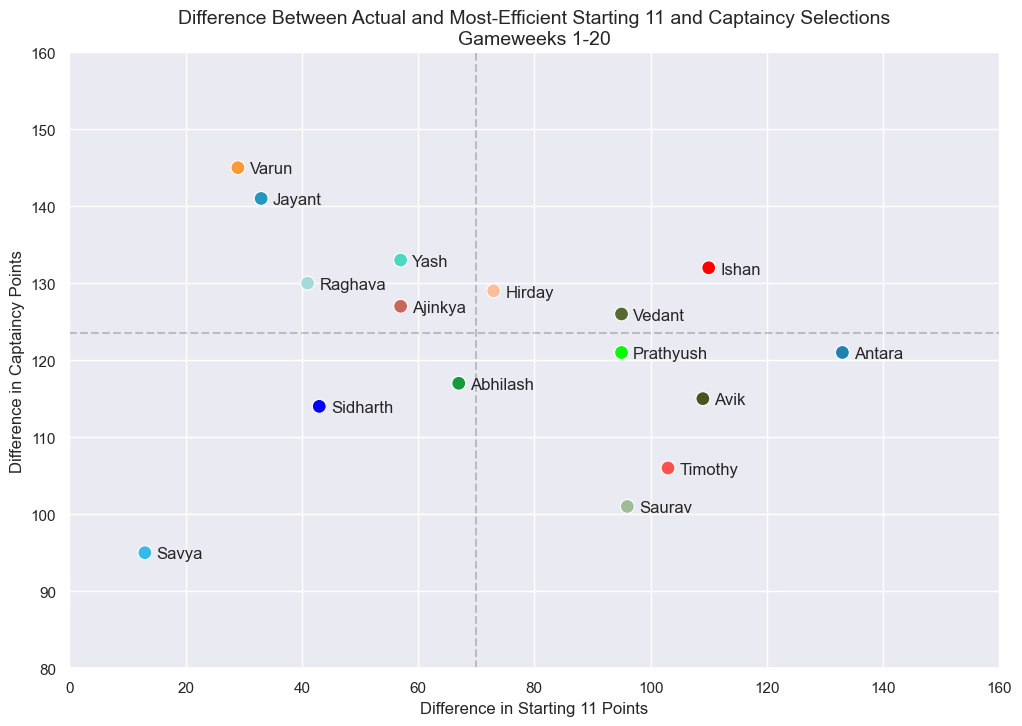

In [9]:
sns.set(style = 'darkgrid')
f, ax = plt.subplots(figsize = (12, 8))
median_x = df_efficiency['starting11_diff'].median()
median_y = df_efficiency['captaincy_diff'].median()
ax = sns.scatterplot(x = 'starting11_diff', y = 'captaincy_diff', hue = 'player_name',
                     palette = df_efficiency['palette'].tolist(), data = df_efficiency, s = 100)
ax.set_xlabel('Difference in Starting 11 Points', fontsize = 12)
ax.set_ylabel('Difference in Captaincy Points', fontsize = 12)
ax.set_xlim(0, 160)
ax.set_ylim(80, 160)
ax.set_title('Difference Between Actual and Most-Efficient Starting 11 and Captaincy Selections\nGameweeks 1-20', fontsize = 14)
sns.despine(left = False, bottom = False)
ax.legend_.remove()
plt.axvline(x = median_x, color = 'black', linestyle = '--', alpha = 0.2)
plt.axhline(y = median_y, color = 'black', linestyle = '--', alpha = 0.2)
players = df_efficiency['player_name'].tolist()
for i, txt in enumerate(players):
    ax.annotate(txt, (df_efficiency['starting11_diff'][i] + 2, df_efficiency['captaincy_diff'][i] - 0.75))